## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./

--2023-11-23 12:34:52--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 2620:100:6025:18::a27d:4512, 162.125.69.18
Connessione a www.dropbox.com (www.dropbox.com)|2620:100:6025:18::a27d:4512|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: /s/raw/xvjzaxzz3ysphme/data_000637.txt [segue]
--2023-11-23 12:34:52--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Riutilizzo della connessione esistente a [www.dropbox.com]:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc71e8bf6571e10138faea24f275.dl.dropboxusercontent.com/cd/0/inline/CIHeejXcLNdtc42_fBQ-t7bxKaQzL9QPvbKb2O8ce4eiBqZBW1Q9HXVAW91d0-PrHffZ9lQFwkS5gQLqTWnYUlQLKxgiIS4rFlUYPVtNDv9jKStP8fwnrZmyf85aygOQg6g/file# [segue]
--2023-11-23 12:34:52--  https://uc71e8bf6571e10138faea24f275.dl.dropboxusercontent.com/cd/0/inline/CIHeejXcLNdtc42_fBQ-t7bxKaQzL9QPvbKb2O8ce4eiBqZBW1Q9HXVAW91d0-PrHffZ9

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Exercise 1
Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger than 10k.

In [3]:
# input file is in csv format, hence:
df = pd.read_csv('data_000637.txt')
df.describe()

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
count,1310720.0,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06,1.310720e+06
mean,1.0,2.959198e-01,5.582570e+01,3.869206e+09,1.781096e+03,1.332340e+01
std,0.0,4.564553e-01,3.901034e+01,3.183124e+03,1.027795e+03,9.199886e+00
min,1.0,0.000000e+00,1.000000e+00,3.869200e+09,0.000000e+00,0.000000e+00
25%,1.0,0.000000e+00,2.600000e+01,3.869203e+09,8.930000e+02,5.000000e+00
50%,1.0,0.000000e+00,5.700000e+01,3.869207e+09,1.778000e+03,1.300000e+01
75%,1.0,1.000000e+00,6.400000e+01,3.869209e+09,2.670000e+03,2.100000e+01
max,1.0,1.000000e+00,1.390000e+02,3.869211e+09,3.563000e+03,2.900000e+01


Notes: TDC_MEAS has 30 bins, they cover a range of 25 nanoseconds. If I count 10, the time is 10*25/30 ns 
count from 0 to 29 and then goes back to 0, resets. When it resets the next counter gets updated.
BX_COUNTER is the next unit. Need to find the value 'x' at which BX_COUNTER gets reset.
The next after BX_COUNTER is the ORBIT_CNT.

So BX_counter is multiple of 25 ns, since every 25 ns the TDC_MEAS goes to 0.

the device has several channels, and the channels are marked by FPGA and TDC_CHANNEL.

#### Exercise 2
Find out the number of BX in a ORBIT (the value 'x').

count    11001.000000
mean      3280.181438
std        458.559839
min         15.000000
25%       3274.000000
50%       3441.000000
75%       3519.000000
max       3563.000000
Name: BX_COUNTER, dtype: float64

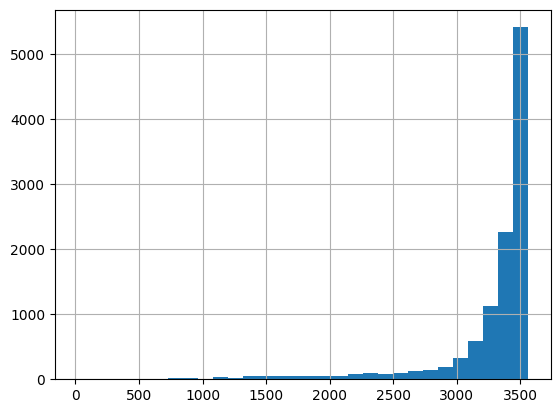

In [4]:
things = df.groupby('ORBIT_CNT')['BX_COUNTER'].max()
things.hist(bins=30)
things.describe()

In [5]:
# the requested BX value that resets BX and makes the orbit go up by 1 will be the highest BX_COUNTER found, so:
bx_max = things.max()+1
print(f"BX 'x' value is {bx_max}")

BX 'x' value is 3564


#### Exercise 3
Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [6]:
'''
so, the initial value is given by the number of orbits + bx + the fine measurement of the tdc. So:
'''
def ns_time(df, bx_max):
    t = {'ORBIT':0,'BX':0,'TDC':0}
    t['TDC'] = df['TDC_MEAS']*25/30.
    t['BX'] = df['BX_COUNTER']*25.
    t['ORBIT'] = df['ORBIT_CNT']*bx_max*25.
    return t['TDC']+t['BX']+t['ORBIT']

start_time_ns = ns_time(df.iloc[0], bx_max)
stop_time_ns = ns_time(df.iloc[df.shape[0]-1], bx_max)
run_time_ns = stop_time_ns - start_time_ns
print(f"Total run time is {run_time_ns} ns ({run_time_ns/10**9} s)")

Total run time is 980416093.3125 ns (0.9804160933125 s)


#### Exercise 4
Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [7]:
df['ABS_T'] = (df['TDC_MEAS']*25/30)+(df['BX_COUNTER']*25)+(df['ORBIT_CNT']*bx_max*25)

#### Exercise 5
Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [8]:
df['HEAD'] = np.random.randint(2, size=df.shape[0])

#### Exercise 6
Create a new DataFrame that contains only the rows with HEAD=1

In [9]:
df_head1 = df[df['HEAD']==1]

#### Exercise 7
Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

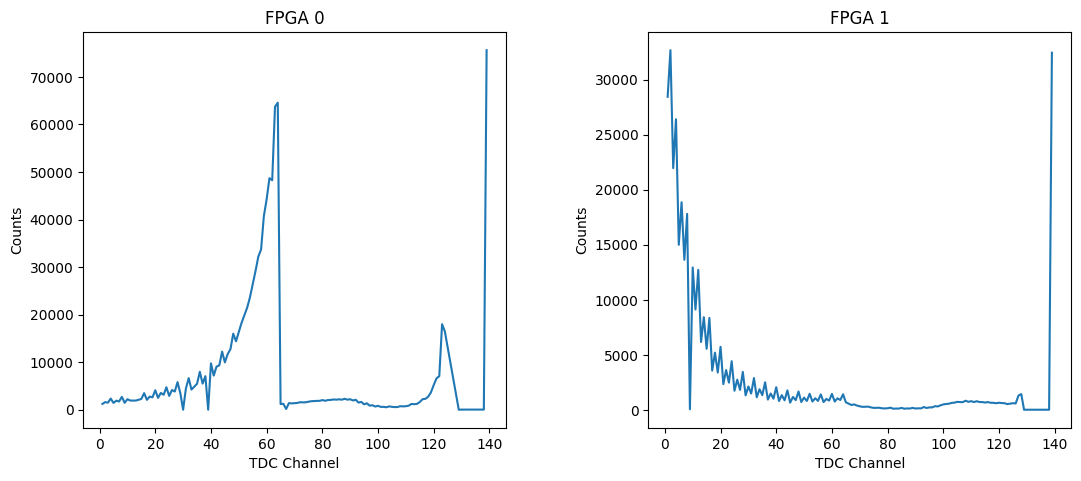

In [10]:
df_fpga0 = df[df['FPGA']==0]
df_fpga1 = df[df['FPGA']==1]
grouped_0 = df_fpga0.groupby('TDC_CHANNEL', dropna=False)
grouped_1 = df_fpga1.groupby('TDC_CHANNEL', dropna=False)
counts_0 = grouped_0.count()
counts_1 = grouped_1.count()

figure, axis = plt.subplots(1, 2)
figure.set_figwidth(12)
figure.set_figheight(6)

axis[0].plot(counts_0.axes[0], counts_0['FPGA']) 
axis[0].set_title("FPGA 0") 
axis[0].set_xlabel("TDC Channel")
axis[0].set_ylabel("Counts")
axis[1].plot(counts_1.axes[0], counts_1['FPGA'])
axis[1].set_title("FPGA 1") 
axis[1].set_xlabel("TDC Channel")
axis[1].set_ylabel("Counts")
figure.tight_layout(pad=5.0)

plt.show()


#### Exercise 8
Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [11]:
v = grouped_0['HEAD'].count()
v = v.sort_values()
print("FPGA_0")
for i in range(v.shape[0]-1,v.shape[0]-4,-1):
    print(f"TDC channel {v.axes[0][i]} = {v.iloc[i]}")
print()
v1 = grouped_1['HEAD'].count()
v1 = v1.sort_values()
print("FPGA_1")
for i in range(v1.shape[0]-1,v1.shape[0]-4,-1):
    print(f"TDC channel {v1.axes[0][i]} = {v1.iloc[i]}")

FPGA_0
TDC channel 139 = 75617
TDC channel 64 = 64581
TDC channel 63 = 63724

FPGA_1
TDC channel 2 = 32669
TDC channel 139 = 32442
TDC channel 1 = 28438


#### Exercise 9
Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [12]:
n_of_unique_orbits = df.groupby('ORBIT_CNT').count().shape[0]
print(f"Number of unique orbits: {n_of_unique_orbits}")

n_uniq_139 = df[df['TDC_CHANNEL']==139].groupby('ORBIT_CNT').count().shape[0]
print(f"Number of unique orbits with at least one meas from TDC_CHANNEL=139: {n_uniq_139}")

Number of unique orbits: 11001
Number of unique orbits with at least one meas from TDC_CHANNEL=139: 10976
